# CSE-CIC-IDS 2017

In [1]:
model_id = "cnn4-deeper"

In [2]:
import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import glob, time, os

import keras

Using TensorFlow backend.
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Us

In [3]:
NOTEBOOK_PATH = "C:/Users/Xetrov/Desktop/SciFair20/Code/"

In [4]:
x_scaled = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_scaled_powertransform.csv")

In [5]:
y_df_enc = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_grouped_1henc.csv")

# Reshape into images

In [6]:
x_img = x_scaled.to_numpy().reshape((len(x_scaled), 4, 17))

In [7]:
x_img = np.expand_dims(x_img, -1)

# Split data into train and test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_valtest, y_train, y_valtest = train_test_split(x_img, y_df_enc, test_size = 0.4, random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, random_state = 42)

del x_valtest 
del y_valtest

# Read ADASYN data

In [10]:
x_train_res = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_adasyn.csv").to_numpy()

In [11]:
y_train_res = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_adasyn.csv")

y_train_res2 = pd.get_dummies(y_train_res[y_train_res.columns[0]])

In [12]:
x_train_resimg = np.expand_dims(x_train_res.reshape((len(x_train_res), 4, 17)), -1)

# Train model

In [13]:
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Conv2D, Flatten
from keras.optimizers import SGD, Adam

In [14]:
def addDenseBlock(model, units, **params):
    model.add(Dense(units=units, activation=params['hidden_activation'], input_dim=x_train.shape[1]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))

def addConvBlock(model, units, **params):
    model.add(Conv2D(filters=units, kernel_size=params['kernel_size'], activation=params['hidden_activation'], padding=params['padding'],input_shape=(4,17,1)))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))
        
def createModel(**in_params):
    """
    Supported parameters:
    batch_normalization - True or False
    dropout_rate - 0 to 1
    num_units - integer
    learning_rate - float
    activation_function - string
    """
    
    model = Sequential()

    # Set default values
    params = {
        'batch_normalization': False,
        'dropout_rate': 0,
        'num_layers': 6,
        'num_units': 128,
        'learning_rate': 0.001,
        'hidden_activation': 'relu',
        'final_activation': 'softmax',
        'kernel_size': (2,2),
        'padding':'same'
    }
    
    # Replace defaults with specified parameters
    for param in in_params:
        params[param] = in_params[param]    
    
    # InputLayer causes serialization issues
#     model.add( InputLayer(input_shape = (x_train.shape[1],) ) )
    
#     for i in range(params['num_layers']):
#         addDenseBlock(model, params['num_units'], **params)

    addConvBlock(model, 64, **params)
    addConvBlock(model, 128, **params)
    addConvBlock(model, 256, **params)
    addConvBlock(model, 128, **params)
    addConvBlock(model, 64, **params)
    
    model.add(Flatten())

    model.add(Dense(units=y_train.shape[1], activation=params['final_activation']))

    # optim = SGD(lr=0.001, nesterov=True)
    optim = Adam(lr=params['learning_rate'])

    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
#     print(params)
    
    return model

Ensure a GPU is available

In [15]:
import keras.backend as K

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Callbacks

In [16]:
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

def timestamp():
    return time.strftime("%m-%d-%Y, %I%M%p")

csv_callback = CSVLogger(NOTEBOOK_PATH + 'Loss Logs/%s (%s)' % (model_id, timestamp()), append=True)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5)

### Model Saving

In [17]:
savedir = NOTEBOOK_PATH + "Models/%s/" % model_id
if not os.path.exists(savedir):
    os.makedirs(savedir)
    print("Created " + savedir)
else:
    print("Using " + savedir)

Created C:/Users/Xetrov/Desktop/SciFair20/Code/Models/cnn4-adasyn/


### Training

In [20]:
import itertools

trainEpochs = 38

parameters = {'batch_size': 250, 'batch_normalization':True, 'dropout_rate':0}

In [21]:
%%time
# print(model_id)
# model = createModel(**parameters)
model = keras.models.load_model(NOTEBOOK_PATH + "Models/cnn4-adasyn-run1/cnn(4).h5")
model.summary()
model_checkpoint = ModelCheckpoint(NOTEBOOK_PATH + "Models/%s/cnn({epoch}).h5" % (model_id), monitor='val_loss')
model.fit(x_train_resimg, y_train_res2, validation_data=(x_val, y_val), batch_size=parameters['batch_size'], initial_epoch=4, epochs=trainEpochs, verbose=2, callbacks=[csv_callback, model_checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 4, 17, 64)         320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 17, 64)         256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 17, 128)        32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 17, 128)        512       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 17, 256)        131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 17, 256)        1024      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 17, 128)        131200    
__________

In [43]:
y_train.shape

(2547668, 10)

# Graph the losses

In [24]:
def most_recent_file(pattern):
    return max(glob.iglob(pattern, recursive=True), key=os.path.getctime)

logpath = most_recent_file(NOTEBOOK_PATH + "Loss Logs/%s**" % model_id)
log_df = pd.read_csv(logpath)
log_df['epoch'] += 1

print(logpath)

C:/Users/Xetrov/Desktop/SciFair20/Code/Loss Logs\cnn4-adasyn (10-15-2019, 1008PM)


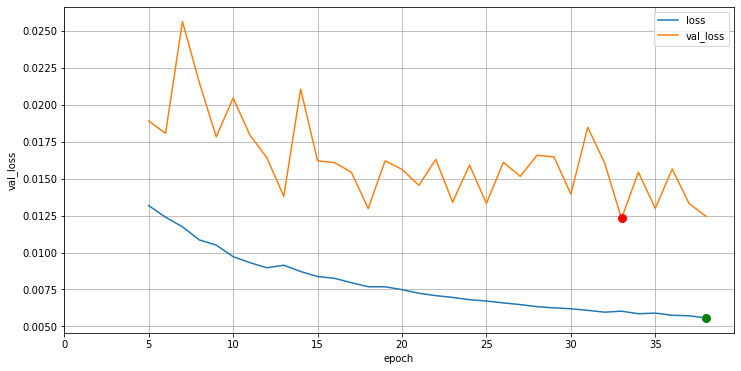

In [25]:
plot_df = log_df[:]

metric = 'loss'

plt.figure(figsize=(12,6))
sns.lineplot(x='epoch', y=metric, data=plot_df, label=metric)
sns.lineplot(x='epoch', y='val_'+metric, data=plot_df, label='val_'+metric)
plt.legend()

minEpoch = plot_df.loc[plot_df.idxmin()[metric]]
plt.plot((minEpoch['epoch']), (minEpoch[metric]), 'go', markersize=8)
minEpoch = plot_df.loc[plot_df.idxmin()['val_'+metric]]
plt.plot((minEpoch['epoch']), (minEpoch['val_'+metric]), 'ro', markersize=8)

plt.xticks(list(range(0, plot_df['epoch'].max()+1, 5)))
# plt.yticks(list(np.arange(0.0,0.4,0.05)))

plt.grid(True)

# Validation data

In [26]:
print("Loading...")
model = keras.models.load_model(NOTEBOOK_PATH + "Models/%s/cnn(33).h5" % model_id)
print("Predicting...")
pred = model.predict(x_val)

print("Plotting...")
pred_index = list(pred.argmax(1))
y_index = list(np.argmax(y_val.to_numpy(), axis=1))

atktypes = sorted(y_val.columns)
pred_series = pd.Series(pred_index, name="Pred").replace(dict(enumerate(atktypes)))
y_series = pd.Series(y_index, name="Actual").replace(dict(enumerate(atktypes)))

matrix = pd.crosstab(pred_series, y_series, margins=True)
print("Done!")
matrix

Loading...
Predicting...
Plotting...
Done!


Actual,BENIGN,Botnet,Brute Force,DoS/DDoS,Infiltration,PortScan,Web Attack,All
Pred,,,,,,,,
BENIGN,452960,10,0,10,0,1,2,452983
Botnet,647,387,0,0,0,0,0,1034
Brute Force,32,0,2810,0,0,0,0,2842
DoS/DDoS,361,0,0,76478,0,4,9,76852
Infiltration,8,0,0,0,7,0,0,15
PortScan,195,0,0,20,0,31780,53,32048
Web Attack,4,0,0,2,0,2,367,375
All,454207,397,2810,76510,7,31787,431,566149


# Test data

In [27]:
from sklearn.metrics import f1_score

In [29]:
# model = keras.models.load_model(NOTEBOOK_PATH + "Models/%s/cnn(50).h5" % model_id)
pred = model.predict(x_test, batch_size=256).argmax(axis=1)
pred_f1 = np.zeros((len(x_test), y_test.shape[1]))
for j in range(len(pred)):
    pred_f1[j,pred[j]] = 1
f1_micro = f1_score(y_test, pred_f1.astype('uint8'), average='micro')
f1_macro = f1_score(y_test, pred_f1.astype('uint8'), average='macro')
print("Micro:", f1_micro)
print("Macro:", f1_macro)

Micro: 0.9975801423300227
Macro: 0.8621414282361128


In [30]:
pred_index = pred
y_index = list(np.argmax(y_test.to_numpy(), axis=1))

atktypes = sorted(y_test.columns)
pred_series = pd.Series(pred_index, name="Pred").replace(dict(enumerate(atktypes)))
y_series = pd.Series(y_index, name="Actual").replace(dict(enumerate(atktypes)))

matrix = pd.crosstab(pred_series, y_series, margins=True)
print("Done!")
matrix.to_csv(NOTEBOOK_PATH + "Confusion Matrices/%s.csv" % model_id)
matrix

Done!


Actual,BENIGN,Botnet,Brute Force,DoS/DDoS,Infiltration,PortScan,Web Attack,All
Pred,,,,,,,,
BENIGN,453520,11,4,10,0,3,0,453548
Botnet,644,373,0,0,0,0,0,1017
Brute Force,25,0,2748,0,0,0,1,2774
DoS/DDoS,380,0,0,75863,0,2,5,76250
Infiltration,7,0,0,0,5,0,0,12
PortScan,200,0,0,22,0,31870,39,32131
Web Attack,14,0,0,2,0,1,400,417
All,454790,384,2752,75897,5,31876,445,566149


# Log results

In [31]:
model_log = open(NOTEBOOK_PATH + "model_log.txt", "a")

model_log.write("\n" + model_id)
model_log.write("\n\tF1 Micro: " + str(f1_micro))
model_log.write("\n\tF1 Macro: " + str(f1_macro))

model_log.close()